Generating datasets...
Train samples: 400
Validation samples: 100
Test (0.2 noise) samples: 500
Using device: cpu

 - Training Model 1: MLP + Early Stopping -
Model 1 training complete.

 - Training Model 2: MLP + L1 Regularization (Grid Search) -
Best L1 Lambda: 1e-06
L1 Grid Search Results:
     lambda  value_auroc  sparsity_layer_1  sparse_count_layer_1  \
0  0.000001     0.995974          0.003906                     1   
1  0.000003     0.995974          0.011719                     3   
2  0.000010     0.995974          0.019531                     5   
3  0.000030     0.995974          0.039062                    10   
4  0.000100     0.995974          0.101562                    26   
5  0.000300     0.995974          0.058594                    15   

   sparsity_layer_2  sparse_count_layer_2  sparsity_total  sparse_count_total  
0          0.000000                     0        0.002604                   1  
1          0.007812                     1        0.010417            

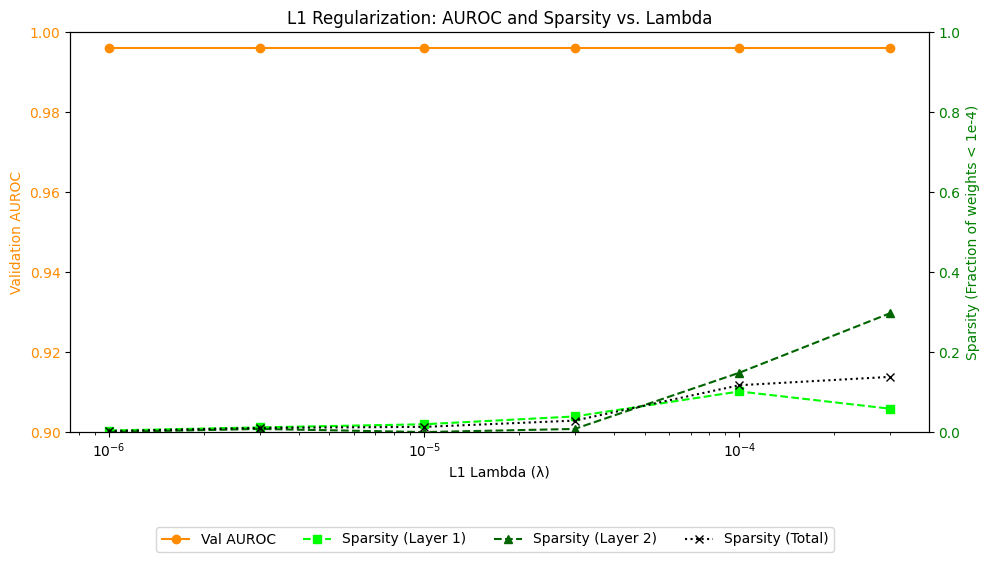

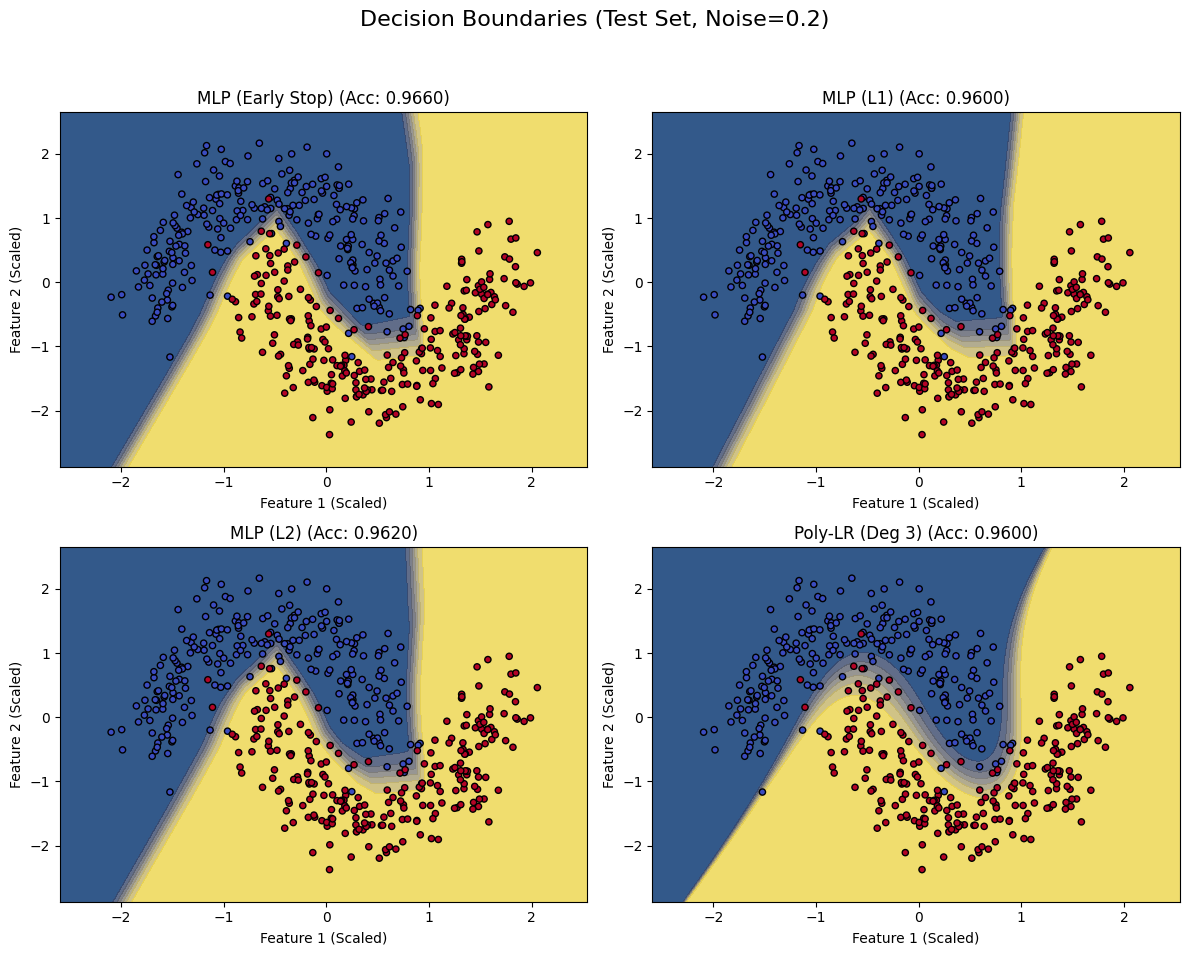

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
import pandas as pd
import copy

# Set random seeds for reproducibility
RANDOM_SEED = 1337
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# 1. Custom Make-Moons Dataset Generation

def generate_moon_data(total_samples=100, perturbation_level=0.0, seed_value=None):
    if seed_value is not None:
        np.random.seed(seed_value)

    num_samples_low = total_samples // 2
    num_samples_high = total_samples - num_samples_low

    theta_out = np.linspace(0, np.pi, num_samples_low)
    feature1_out = np.cos(theta_out)
    feature2_out = np.sin(theta_out)

    theta_in = np.linspace(0, np.pi, num_samples_high)
    feature1_in = 1 - np.cos(theta_in)
    feature2_in = 0.5 - np.sin(theta_in)

    features = np.vstack([np.column_stack([feature1_out, feature2_out]),
                          np.column_stack([feature1_in, feature2_in])])
    labels = np.hstack([np.zeros(num_samples_low), np.ones(num_samples_high)])

    if perturbation_level > 0:
        features += np.random.normal(scale=perturbation_level, size=features.shape)

    return features, labels

# 2. Data Generation and Splitting

print("Generating datasets...")
X_data_full, y_labels_full = generate_moon_data(total_samples=500, perturbation_level=0.2, seed_value=RANDOM_SEED)

X_test_noise_02, y_test_noise_02 = generate_moon_data(total_samples=500, perturbation_level=0.2, seed_value=RANDOM_SEED + 1)
X_test_noise_01, y_test_noise_01 = generate_moon_data(total_samples=500, perturbation_level=0.1, seed_value=RANDOM_SEED + 2)
X_test_noise_03, y_test_noise_03 = generate_moon_data(total_samples=500, perturbation_level=0.3, seed_value=RANDOM_SEED + 3)

X_train_raw, X_validate_raw, y_train_raw, y_validate_raw = train_test_split(
    X_data_full, y_labels_full, test_size=0.2, random_state=RANDOM_SEED
)

print(f"Train samples: {X_train_raw.shape[0]}")
print(f"Validation samples: {X_validate_raw.shape[0]}")
print(f"Test (0.2 noise) samples: {X_test_noise_02.shape[0]}")

# 3. Standardization (Manual)

training_mean = np.mean(X_train_raw, axis=0)
training_std_dev = np.std(X_train_raw, axis=0)

epsilon = 1e-8

X_train_norm = (X_train_raw - training_mean) / (training_std_dev + epsilon)
X_validate_norm = (X_validate_raw - training_mean) / (training_std_dev + epsilon)
X_test_02_norm = (X_test_noise_02 - training_mean) / (training_std_dev + epsilon)
X_test_01_norm = (X_test_noise_01 - training_mean) / (training_std_dev + epsilon)
X_test_03_norm = (X_test_noise_03 - training_mean) / (training_std_dev + epsilon)

# 4. Convert to PyTorch Tensors
compute_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {compute_device}")

X_train_tensor = torch.tensor(X_train_norm, dtype=torch.float32).to(compute_device)
y_train_tensor = torch.tensor(y_train_raw, dtype=torch.float32).view(-1, 1).to(compute_device)
X_validate_tensor = torch.tensor(X_validate_norm, dtype=torch.float32).to(compute_device)
y_validate_tensor = torch.tensor(y_validate_raw, dtype=torch.float32).view(-1, 1).to(compute_device)

X_test_01_tensor = torch.tensor(X_test_01_norm, dtype=torch.float32).to(compute_device)
X_test_02_tensor = torch.tensor(X_test_02_norm, dtype=torch.float32).to(compute_device)
X_test_03_tensor = torch.tensor(X_test_03_norm, dtype=torch.float32).to(compute_device)

y_test_01_tensor = torch.tensor(y_test_noise_01, dtype=torch.float32).view(-1, 1).to(compute_device)
y_test_02_tensor = torch.tensor(y_test_noise_02, dtype=torch.float32).view(-1, 1).to(compute_device)
y_test_03_tensor = torch.tensor(y_test_noise_03, dtype=torch.float32).view(-1, 1).to(compute_device)


# 5. MLP Model and Helper Functions

class SimpleMLP(nn.Module):
    def __init__(self, input_features=2, neuron_count=128, output_count=1):
        super(SimpleMLP, self).__init__()
        self.hidden_layer = nn.Linear(input_features, neuron_count)
        self.activation = nn.ReLU()
        self.output_layer = nn.Linear(neuron_count, output_count)

    def forward(self, x):
        x = self.hidden_layer(x)
        x = self.activation(x)
        x = self.output_layer(x)
        return x

def get_total_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def score_model_performance(model, X_input_tensor, y_true_labels):
    model.eval()
    with torch.no_grad():
        logits_output = model(X_input_tensor)
        probabilities = torch.sigmoid(logits_output).cpu().numpy()
        predictions = (probabilities > 0.5).astype(int)

    score_accuracy = accuracy_score(y_true_labels, predictions)
    score_auroc = roc_auc_score(y_true_labels, probabilities)
    return score_accuracy, score_auroc

def train_and_early_stop(model, X_train_t, y_train_t, X_val_t, y_val_t,
                         optimizer, loss_function,
                         max_epochs=1000, patience_limit=50,
                         l1_regularization_strength=0,
                         l2_regularization_strength=0):

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_weights = None

    for epoch_idx in range(max_epochs):
        model.train()

        # Forward pass
        logits = model(X_train_t)
        train_loss = loss_function(logits, y_train_t)

        # Add L1 penalty
        if l1_regularization_strength > 0:
            l1_penalty = 0
            for param in model.parameters():
                l1_penalty += torch.abs(param).sum()
            train_loss += l1_regularization_strength * l1_penalty

        # Add L2 penalty
        if l2_regularization_strength > 0:
            l2_penalty = 0
            for param in model.parameters():
                l2_penalty += param.pow(2).sum()

            train_loss += 0.5 * l2_regularization_strength * l2_penalty

        # Backward pass and optimization
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_logits = model(X_val_t)
            val_loss = loss_function(val_logits, y_val_t)

            # Add penalties to validation loss for a fair comparison
            if l1_regularization_strength > 0:
                l1_penalty_val = 0
                for param in model.parameters():
                    l1_penalty_val += torch.abs(param).sum()
                val_loss += l1_regularization_strength * l1_penalty_val

            if l2_regularization_strength > 0:
                l2_penalty_val = 0
                for param in model.parameters():
                    l2_penalty_val += param.pow(2).sum()
                val_loss += 0.5 * l2_regularization_strength * l2_penalty_val

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_weights = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience_limit:
            break

    model.load_state_dict(best_weights)
    return model
# 6. Model 1: MLP with Early Stopping

print("\n - Training Model 1: MLP + Early Stopping -")
model_early_stop = SimpleMLP().to(compute_device)
optimizer_early_stop = optim.Adam(model_early_stop.parameters(), lr=0.01)
binary_cross_entropy = nn.BCEWithLogitsLoss()

model_early_stop = train_and_early_stop(
    model_early_stop, X_train_tensor, y_train_tensor, X_validate_tensor, y_validate_tensor,
    optimizer_early_stop, binary_cross_entropy, patience_limit=50
)
print("Model 1 training complete.")
param_count_es = get_total_parameters(model_early_stop)


# 7. Model 2: MLP with L1 Regularization

print("\n - Training Model 2: MLP + L1 Regularization (Grid Search) -")
l1_strength_values = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4]
l1_search_results = []
l1_model_candidates = {}

def measure_sparsity(model, zero_threshold=1e-4):
    layer_sparsity = {}
    total_weights = 0
    total_sparse = 0

    for name, param in model.named_parameters():
        if 'weight' in name:
            weights = param.data.cpu().numpy()
            num_weights = weights.size
            num_sparse = np.sum(np.abs(weights) < zero_threshold)
            sparsity_ratio = num_sparse / num_weights

            layer_sparsity[name] = {
                'sparse_count': int(num_sparse),
                'total_count': int(num_weights),
                'sparsity_ratio': sparsity_ratio
            }

            total_weights += num_weights
            total_sparse += num_sparse

    layer_sparsity['total'] = {
        'sparse_count': int(total_sparse),
        'total_count': int(total_weights),
        'sparsity_ratio': total_sparse / total_weights
    }

    return layer_sparsity


for l1_reg_strength in l1_strength_values:
    model_l1_grid = SimpleMLP().to(compute_device)
    optimizer_l1 = optim.Adam(model_l1_grid.parameters(), lr=0.01)

    model_l1_grid = train_and_early_stop(
        model_l1_grid, X_train_tensor, y_train_tensor, X_validate_tensor, y_validate_tensor,
        optimizer_l1, binary_cross_entropy, patience_limit=50, l1_regularization_strength=l1_reg_strength
    )

    _, value_auroc = score_model_performance(model_l1_grid, X_validate_tensor, y_validate_raw)
    sparsity_info = measure_sparsity(model_l1_grid)

    l1_search_results.append({
    'lambda': l1_reg_strength,
    'value_auroc': value_auroc,

    'sparsity_layer_1': sparsity_info['hidden_layer.weight']['sparsity_ratio'],
    'sparse_count_layer_1': sparsity_info['hidden_layer.weight']['sparse_count'],
    'sparsity_layer_2': sparsity_info['output_layer.weight']['sparsity_ratio'],
    'sparse_count_layer_2': sparsity_info['output_layer.weight']['sparse_count'],
    'sparsity_total': sparsity_info['total']['sparsity_ratio'],
    'sparse_count_total': sparsity_info['total']['sparse_count'],

})
    l1_model_candidates[l1_reg_strength] = model_l1_grid

l1_results_df = pd.DataFrame(l1_search_results)
best_l1_strength = l1_results_df.loc[l1_results_df['value_auroc'].idxmax()]['lambda']
final_model_l1 = l1_model_candidates[best_l1_strength]

print(f"Best L1 Lambda: {best_l1_strength}")
print("L1 Grid Search Results:")
print(l1_results_df)

param_count_l1 = get_total_parameters(final_model_l1)

# Plot L1 results - UPDATED COLORS
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.set_xscale('log')
ax1.set_xlabel('L1 Lambda (λ)')
ax1.set_ylabel('Validation AUROC', color='darkorange')
ax1.plot(l1_results_df['lambda'], l1_results_df['value_auroc'], 'o-', color='darkorange', label='Val AUROC')
ax1.tick_params(axis='y', labelcolor='darkorange')
ax1.set_ylim(0.9, 1.0)

ax2 = ax1.twinx()
ax2.set_ylabel('Sparsity (Fraction of weights < 1e-4)', color='green')
ax2.plot(l1_results_df['lambda'], l1_results_df['sparsity_layer_1'], 's--', color='lime', label='Sparsity (Layer 1)')
ax2.plot(l1_results_df['lambda'], l1_results_df['sparsity_layer_2'], '^--', color='darkgreen', label='Sparsity (Layer 2)')
ax2.plot(l1_results_df['lambda'], l1_results_df['sparsity_total'], 'x:k', label='Sparsity (Total)')
ax2.tick_params(axis='y', labelcolor='green')
ax2.set_ylim(0, 1.0)

fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4)
plt.title('L1 Regularization: AUROC and Sparsity vs. Lambda')
fig.tight_layout()
plt.savefig("l1_regularization_plot.png", bbox_inches='tight')
print("Saved L1 sparsity/AUROC plot to l1_regularization_plot.png")


# 8. Model 3: MLP with L2 Regularization

print("\n - Training Model 3: MLP + L2 Regularization (Grid Search - Manual) -")
l2_strength_values = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
l2_search_results = []
l2_model_candidates = {}

for l2_reg_strength in l2_strength_values:
    model_l2_grid = SimpleMLP().to(compute_device)

    optimizer_l2 = optim.Adam(model_l2_grid.parameters(), lr=0.01)

    model_l2_grid = train_and_early_stop(
        model_l2_grid, X_train_tensor, y_train_tensor, X_validate_tensor, y_validate_tensor,
        optimizer_l2, binary_cross_entropy, patience_limit=50,
        l2_regularization_strength=l2_reg_strength
    )

    _, value_auroc = score_model_performance(model_l2_grid, X_validate_tensor, y_validate_raw)

    l2_search_results.append({
        'weight_decay': l2_reg_strength,
        'value_auroc': value_auroc,
    })
    l2_model_candidates[l2_reg_strength] = model_l2_grid

l2_results_df = pd.DataFrame(l2_search_results)
best_l2_strength = l2_results_df.loc[l2_results_df['value_auroc'].idxmax()]['weight_decay']
final_model_l2 = l2_model_candidates[best_l2_strength]

print(f"Best L2 Lambda (from manual): {best_l2_strength}")
print("L2 Grid Search Results:")
print(l2_results_df)

param_count_l2 = get_total_parameters(final_model_l2)


# 9. Model 4: Logistic Regression with Polynomial Features

print("\n - Training Model 4: Polynomial Logistic Regression (Grid Search) -")
poly_feature_creator = PolynomialFeatures(degree=3, include_bias=False)

X_train_poly = poly_feature_creator.fit_transform(X_train_norm)
X_val_poly = poly_feature_creator.transform(X_validate_norm)

scaler_poly = StandardScaler()
X_train_poly_norm = scaler_poly.fit_transform(X_train_poly)
X_val_poly_norm = scaler_poly.transform(X_val_poly)

c_inverse_reg_values = [0.001, 0.01, 0.1, 1, 10, 100]
best_c_value = None
max_value_auroc = -1
best_lr_model = None

for c_value in c_inverse_reg_values:
    log_reg = LogisticRegression(solver='liblinear', penalty='l2', C=c_value, random_state=RANDOM_SEED)
    log_reg.fit(X_train_poly_norm, y_train_raw)

    val_probs = log_reg.predict_proba(X_val_poly_norm)[:, 1]
    value_auroc = roc_auc_score(y_validate_raw, val_probs)

    if value_auroc > max_value_auroc:
        max_value_auroc = value_auroc
        best_c_value = c_value
        best_lr_model = log_reg

final_model_poly_lr = best_lr_model
print(f"Best C for Poly-LR: {best_c_value}")

# Define the Poly-LR pipeline for evaluation (takes 2 scaled features, outputs probability)
final_poly_lr_pipeline_predict = Pipeline([
    ('poly', poly_feature_creator),
    ('scaler_poly', scaler_poly),
    ('lr', final_model_poly_lr)
])

param_count_lr = final_model_poly_lr.coef_.size + final_model_poly_lr.intercept_.size
print(f"Poly-LR features: {X_train_poly_norm.shape[1]}")
print(f"Poly-LR param count: {param_count_lr}")


# 10. Evaluation and Analysis

print("\n- Evaluation on Test Sets -")

model_registry = {
    'MLP (Early Stop)': model_early_stop,
    'MLP (L1)': final_model_l1,
    'MLP (L2)': final_model_l2,
    'Poly-LR (Deg 3)': final_poly_lr_pipeline_predict
}

parameter_counts = {
    'MLP (Early Stop)': param_count_es,
    'MLP (L1)': param_count_l1,
    'MLP (L2)': param_count_l2,
    'Poly-LR (Deg 3)': param_count_lr
}

test_datasets_mlp = {
    'Noise 0.1': (X_test_01_tensor, y_test_noise_01),
    'Noise 0.2': (X_test_02_tensor, y_test_noise_02),
    'Noise 0.3': (X_test_03_tensor, y_test_noise_03),
}

test_datasets_lr = {
    'Noise 0.1': (X_test_01_norm, y_test_noise_01),
    'Noise 0.2': (X_test_02_norm, y_test_noise_02),
    'Noise 0.3': (X_test_03_norm, y_test_noise_03),
}

final_results = []
test_auroc_on_noise_02 = {}

for model_name, model_instance in model_registry.items():
    result_row = {'Model': model_name, 'Param Count': parameter_counts[model_name]}

    if 'MLP' in model_name:
        for noise_name, (X_test_t, y_test) in test_datasets_mlp.items():
            acc, auroc = score_model_performance(model_instance, X_test_t, y_test)
            result_row[f'Acc ({noise_name})'] = acc
            if noise_name == 'Noise 0.2':
                result_row['AUROC (Noise 0.2)'] = auroc
                test_auroc_on_noise_02[model_name] = {'Balanced': auroc}
    else:
        for noise_name, (X_test_np, y_test) in test_datasets_lr.items():
            predictions = model_instance.predict(X_test_np)
            acc = accuracy_score(y_test, predictions)
            result_row[f'Acc ({noise_name})'] = acc
            if noise_name == 'Noise 0.2':
                probs = model_instance.predict_proba(X_test_np)[:, 1]
                auroc = roc_auc_score(y_test, probs)
                result_row['AUROC (Noise 0.2)'] = auroc
                test_auroc_on_noise_02[model_name] = {'Balanced': auroc}
    final_results.append(result_row)

results_df = pd.DataFrame(final_results)
results_df = results_df[['Model', 'Param Count', 'Acc (Noise 0.1)', 'Acc (Noise 0.2)', 'Acc (Noise 0.3)', 'AUROC (Noise 0.2)']]

print("\n- Model Comparison on Balanced Data -")
print(results_df.to_markdown(index=False, floatfmt=".4f"))


# 11. Plot Decision Boundaries (on noise=0.2 test set)

print("\nPlotting decision boundaries...")
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Decision Boundaries (Test Set, Noise=0.2)', fontsize=16)

# Create meshgrid
X_plot = X_test_02_norm
x_min, x_max = X_plot[:, 0].min() - 0.5, X_plot[:, 0].max() + 0.5
y_min, y_max = X_plot[:, 1].min() - 0.5, X_plot[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
grid_points_np = np.c_[xx.ravel(), yy.ravel()]
grid_points_t = torch.tensor(grid_points_np, dtype=torch.float32).to(compute_device)

custom_cmap = plt.cm.cividis
scatter_cmap = plt.cm.coolwarm

for ax, (name, model_instance) in zip(axes.ravel(), model_registry.items()):
    if 'MLP' in name:
        model_instance.eval()
        with torch.no_grad():
            Z_scores = torch.sigmoid(model_instance(grid_points_t)).cpu().numpy().reshape(xx.shape)
    else:
        Z_scores = model_instance.predict_proba(grid_points_np)[:, 1].reshape(xx.shape)

    acc_value = results_df[results_df['Model'] == name]['Acc (Noise 0.2)'].values[0]

    ax.contourf(xx, yy, Z_scores, alpha=0.8, cmap=custom_cmap)

    ax.scatter(X_plot[:, 0], X_plot[:, 1], c=y_test_noise_02, s=20,
               edgecolor='k', cmap=scatter_cmap)
    ax.set_title(f"{name} (Acc: {acc_value:.4f})")
    ax.set_xlabel('Feature 1 (Scaled)')
    ax.set_ylabel('Feature 2 (Scaled)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("decision_boundaries.png")
print("Saved decision boundaries plot to decision_boundaries.png")


# 12. Class Imbalance Experiment

print("\n - Class Imbalance Experiment (70:30) -")

X_class_majority = X_data_full[y_labels_full == 0]
y_class_majority = y_labels_full[y_labels_full == 0]
X_class_minority = X_data_full[y_labels_full == 1]
y_class_minority = y_labels_full[y_labels_full == 1]

n_class_majority_train = int(len(X_data_full) * 0.5)
n_class_minority_imb = int(n_class_majority_train * (3/7))

print(f"Imbalanced set: {len(X_class_majority)} (Class 0) + {n_class_minority_imb} (Class 1)")

X_class_minority_sub, _, y_class_minority_sub, _ = train_test_split(
    X_class_minority, y_class_minority, train_size=n_class_minority_imb, random_state=RANDOM_SEED
)

X_train_full_imb = np.vstack([X_class_majority, X_class_minority_sub])
y_train_full_imb = np.hstack([y_class_majority, y_class_minority_sub])

X_train_imb_raw, X_val_imb_raw, y_train_imb_raw, y_val_imb_raw = train_test_split(
    X_train_full_imb, y_train_full_imb, test_size=0.2, random_state=RANDOM_SEED
)

scaler_imb = StandardScaler()
X_train_imb_norm = scaler_imb.fit_transform(X_train_imb_raw)
X_val_imb_norm = scaler_imb.transform(X_val_imb_raw)

X_test_02_imb_norm = scaler_imb.transform(X_test_noise_02)

X_train_imb_t = torch.tensor(X_train_imb_norm, dtype=torch.float32).to(compute_device)
y_train_imb_t = torch.tensor(y_train_imb_raw, dtype=torch.float32).view(-1, 1).to(compute_device)
X_val_imb_t = torch.tensor(X_val_imb_norm, dtype=torch.float32).to(compute_device)
y_val_imb_t = torch.tensor(y_val_imb_raw, dtype=torch.float32).view(-1, 1).to(compute_device)
X_test_02_imb_t = torch.tensor(X_test_02_imb_norm, dtype=torch.float32).to(compute_device)

print(f"Imbalanced train samples: {X_train_imb_norm.shape[0]}")
print(f"Imbalanced val samples: {X_val_imb_norm.shape[0]}")
print(f"Balanced test samples: {X_test_02_imb_norm.shape[0]}")


# 13. Retrain and Evaluate Imbalanced Models (FIXED LOGIC)

print("Retraining models on imbalanced data...")

# Model 1 (Imb): MLP + Early Stopping
model_es_imb = SimpleMLP().to(compute_device)
optimizer_es_imb = optim.Adam(model_es_imb.parameters(), lr=0.01)
model_es_imb = train_and_early_stop(
    model_es_imb, X_train_imb_t, y_train_imb_t, X_val_imb_t, y_val_imb_t,
    optimizer_es_imb, binary_cross_entropy, patience_limit=50
)

# Model 2 (Imb): MLP + L1
max_value_auroc_l1_imb = -1
model_l1_imb = None
for l1_reg_strength in l1_strength_values:
    model_l1_grid_imb = SimpleMLP().to(compute_device)
    optimizer_l1_imb = optim.Adam(model_l1_grid_imb.parameters(), lr=0.01)
    model_l1_grid_imb = train_and_early_stop(
        model_l1_grid_imb, X_train_imb_t, y_train_imb_t, X_val_imb_t, y_val_imb_t,
        optimizer_l1_imb, binary_cross_entropy, patience_limit=50, l1_regularization_strength=l1_reg_strength
    )
    _, value_auroc = score_model_performance(model_l1_grid_imb, X_val_imb_t, y_val_imb_raw)
    if value_auroc > max_value_auroc_l1_imb:
        max_value_auroc_l1_imb = value_auroc
        model_l1_imb = model_l1_grid_imb

# Model 3 (Imb): MLP + L2
max_value_auroc_l2_imb = -1
model_l2_imb = None
for l2_reg_strength in l2_strength_values:
    model_l2_grid_imb = SimpleMLP().to(compute_device)
    optimizer_l2_imb = optim.Adam(model_l2_grid_imb.parameters(), lr=0.01)
    model_l2_grid_imb = train_and_early_stop(
        model_l2_grid_imb, X_train_imb_t, y_train_imb_t, X_val_imb_t, y_val_imb_t,
        optimizer_l2_imb, binary_cross_entropy, patience_limit=50,
        l2_regularization_strength=l2_reg_strength
    )
    _, value_auroc = score_model_performance(model_l2_grid_imb, X_val_imb_t, y_val_imb_raw)
    if value_auroc > max_value_auroc_l2_imb:
        max_value_auroc_l2_imb = value_auroc
        model_l2_imb = model_l2_grid_imb

# Model 4 (Imb): Poly LR
poly_imb = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly_imb = poly_imb.fit_transform(X_train_imb_norm)
X_val_poly_imb = poly_imb.transform(X_val_imb_norm)

scaler_poly_imb = StandardScaler()
X_train_poly_imb_norm = scaler_poly_imb.fit_transform(X_train_poly_imb)
X_val_poly_imb_norm = scaler_poly_imb.transform(X_val_poly_imb)

best_c_value_imb = None
max_value_auroc_imb = -1
best_lr_model_imb = None
for c_value in c_inverse_reg_values:
    lr_imb = LogisticRegression(solver='liblinear', penalty='l2', C=c_value, random_state=RANDOM_SEED)
    lr_imb.fit(X_train_poly_imb_norm, y_train_imb_raw)
    val_probs_imb = lr_imb.predict_proba(X_val_poly_imb_norm)[:, 1]
    value_auroc_imb = roc_auc_score(y_val_imb_raw, val_probs_imb)
    if value_auroc_imb > max_value_auroc_imb:
        max_value_auroc_imb = value_auroc_imb
        best_c_value_imb = c_value
        best_lr_model_imb = lr_imb


final_poly_lr_pipeline_imb = Pipeline([
    ('poly', poly_imb),
    ('scaler_poly', scaler_poly_imb),
    ('lr', best_lr_model_imb)
])

# Evaluate Imbalanced Models on Balanced Test Set (Noise 0.2)
print("\n Evaluating imbalanced models on balanced test set...")
model_registry_imb = {
    'MLP (Early Stop)': model_es_imb,
    'MLP (L1)': model_l1_imb,
    'MLP (L2)': model_l2_imb,
    'Poly-LR (Deg 3)': final_poly_lr_pipeline_imb
}

for model_name, model_instance in model_registry_imb.items():
    if 'MLP' in model_name:
        _, auroc = score_model_performance(model_instance, X_test_02_imb_t, y_test_noise_02)
    else:
        # X_test_02_imb_norm is the 2-feature standardized test data.
        # Pass this 2-feature data to the pipeline.
        probabilities = model_instance.predict_proba(X_test_02_imb_norm)[:, 1]
        auroc = roc_auc_score(y_test_noise_02, probabilities)

    test_auroc_on_noise_02[model_name]['Imbalanced'] = auroc

# Create final comparison table
comparison_results = []
for model_name, auroc_data in test_auroc_on_noise_02.items():
    comparison_results.append({
        'Model': model_name,
        'AUROC (Balanced Train)': auroc_data['Balanced'],
        'AUROC (Imbalanced Train)': auroc_data['Imbalanced']
    })

results_imb_df = pd.DataFrame(comparison_results)

# Print the second table with new formatting
print("\n - Imbalance Experiment: AUROC Comparison (on Balanced Test Set) -")
print(results_imb_df.to_markdown(index=False, floatfmt=".4f"))
print()